In [96]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import numpy.linalg as lg
import random

In [97]:
a = np.array([1,1, -1, 0.2], dtype = np.float32)
sigma = 1.

def f(x):
    x_degree = np.asarray([x ** d for d in range(4)])
    return np.dot(a, x_degree.T)

def Polytransformations(x, degree = 4):
    return np.apply_along_axis(lambda x: np.asarray([x ** d for d in range(degree)]), 
                                       axis = 0, arr = x).T

def generation_samples(n_points = 100, m = 4):
    x_points = np.random.random(size = n_points) * 4.
    F_x = np.apply_along_axis(lambda x: np.asarray([x ** degree for degree in range(m)]), axis = 0, arr = x_points).T
    noise = np.random.randn(n_points) * sigma
    y_points = np.dot(F_x, a) + noise
    return np.c_[x_points.ravel(), y_points.ravel()]

def f_true(n_samples = 100):
    x = np.linspace(0, 4, n_samples)
    y = np.dot(Polytransformations(x, degree = 4), a)
    return np.c_[x.ravel(), y.ravel()]
    
Data = generation_samples() # [x, y]
Data_true = f_true(n_samples = 100)

In [98]:
class LR_CI():
    def __init__(self, sigma = sigma):
        self._T = 0
        self._V = 0
        self._v = 0
        self._n = 0
        self._sigma = sigma
        
    def update(self, x, y):
        Fx = Polytransformations([x], degree = 4)
        self._T += np.dot(Fx.T, Fx)
        self._V += y ** 2
        self._v += Fx.T * y
        self._n += 1
            
    def f_estimate(self, x):
        Fx = Polytransformations([x], degree = 4)
        return np.dot(Fx, np.dot(lg.inv(self._T), self._v))[0][0]
 
    def error_of_est(self, x):
        Fx = Polytransformations([x], degree = 4)
        return self._sigma * np.dot(Fx, np.dot(lg.inv(self._T), Fx.T))[0][0]
    
    def est_error_of_est(self, x):
        m = 4
        return (((self._V - np.dot(self._v.T, np.dot(lg.inv(self._T), 
                                                    self._v)))/(self._n - m)) * (self.error_of_est(x) / self._sigma))[0][0]
    
    def dropping_params(self):
        self._T = 0
        self._V = 0
        self._v = 0
        self._n = 0
        self._sigma = sigma
        
    def several_points(self, data):
        # data should be a (n_samples, 2) is numpy array massive
        # Перед этим необходимо обнулить каноническую информацию
        if(self._n != 0):
            self.dropping_params()
        assert(self._n == 0)
        for idx, pair in enumerate(data):
            x, y = pair[0], pair[1]
            self.update(x, y)
        # После того как мы обновили всё 
        x_range = np.linspace(0, 4, 1000)
        f_est = np.asarray([self.f_estimate(x) for x in x_range])
        error_est = np.asarray([self.error_of_est(x) for x in x_range])
        est_of_error = np.asarray([self.est_error_of_est(x) for x in x_range])
        return (x_range,f_est, error_est, est_of_error) # f^, D(f^)(x), ^D(f^)(x), 
    

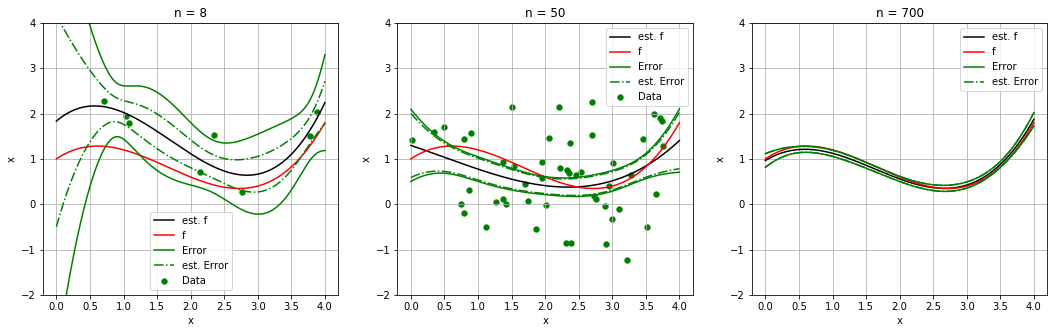

In [99]:
def process_of_updating():
    n_var = np.array([8, 50, 700])
    Data = generation_samples(n_points = 2 * n_var.max(), m = 4)
    fig, ax = plt.subplots(1, 3, figsize = (18, 5))
    for idx, n in enumerate(n_var):
        obj_ci = LR_CI()
        indeces = random.sample(np.arange(Data.shape[0]).tolist(), k = n)
        x_range, f_est, error_est, est_error_est = obj_ci.several_points(Data[indeces])
        Data_true = f_true(n_samples = 1000)
        if(n < 100):
            ax[idx].scatter(Data[indeces, 0], Data[indeces, 1], c = 'green', linewidth = 0.3, label = 'Data')
        ax[idx].plot(x_range, f_est, c = 'black', label = 'est. f')
        ax[idx].plot(Data_true[:, 0], Data_true[:, 1], c = 'red', label = 'f')
        ax[idx].set_ylim((-2, 4))
        ax[idx].grid()
        ax[idx].set_title('n = ' + str(n))
        ax[idx].plot(x_range, f_est + np.sqrt(error_est), c = 'g', label = 'Error')
        ax[idx].plot(x_range, f_est - np.sqrt(error_est), c = 'g')
        ax[idx].plot(x_range, f_est + np.sqrt(est_error_est), c = 'g', linestyle = '-.', label = 'est. Error')
        ax[idx].plot(x_range, f_est - np.sqrt(est_error_est), c = 'g', linestyle = '-.')
        ax[idx].legend()
        ax[idx].set_xlabel('x')
        ax[idx].set_ylabel('x')
    plt.show()
    
process_of_updating();